In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from torchvision import transforms

from datasets import LoadData, PretrainDataset

ds = LoadData('./data')
label_df = ds.load_dataset()
image_df = ds.load_image()

label_df

,TCGA ID,censored,Survival months,Grade,Age at diagnosis,Molecular subtype
0,TCGA-02-0001,0,358,4.0,44,IDHwt
1,TCGA-02-0003,0,144,4.0,50,IDHwt
2,TCGA-02-0006,0,558,4.0,56,IDHwt
3,TCGA-02-0007,0,705,4.0,40,IDHwt
4,TCGA-02-0009,0,322,4.0,61,IDHwt
...,...,...,...,...,...,...
764,TCGA-WY-A85A,1,1320,NaN,20,IDHmut-non-codel
765,TCGA-WY-A85B,1,1393,NaN,24,IDHmut-non-codel
766,TCGA-WY-A85C,1,1426,NaN,36,IDHmut-non-codel
767,TCGA-WY-A85D,1,1147,NaN,60,IDHmut-non-codel


In [2]:
label_df.merge(image_df, on='TCGA ID')

,TCGA ID,censored,Survival months,Grade,Age at diagnosis,Molecular subtype,Filename
0,TCGA-02-0001,0,358,4.0,44,IDHwt,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b15...
1,TCGA-02-0001,0,358,4.0,44,IDHwt,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b15...
2,TCGA-02-0001,0,358,4.0,44,IDHwt,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b15...
3,TCGA-02-0001,0,358,4.0,44,IDHwt,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b15...
4,TCGA-02-0001,0,358,4.0,44,IDHwt,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b15...
...,...,...,...,...,...,...,...
13933,TCGA-WY-A85E,1,633,NaN,48,IDHmut-non-codel,TCGA-WY-A85E-01Z-00-DX1.AA7A4C1F-99AA-490D-B6D...
13934,TCGA-WY-A85E,1,633,NaN,48,IDHmut-non-codel,TCGA-WY-A85E-01Z-00-DX1.AA7A4C1F-99AA-490D-B6D...
13935,TCGA-WY-A85E,1,633,NaN,48,IDHmut-non-codel,TCGA-WY-A85E-01Z-00-DX1.AA7A4C1F-99AA-490D-B6D...
13936,TCGA-WY-A85E,1,633,NaN,48,IDHmut-non-codel,TCGA-WY-A85E-01Z-00-DX1.AA7A4C1F-99AA-490D-B6D...


In [2]:
from sklearn.model_selection import train_test_split

training_set, test_df = train_test_split(label_df.merge(image_df, on='TCGA ID'), test_size=0.1, random_state=1234)
train_df, val_df = train_test_split(training_set, test_size=0.1, random_state=1234)

## Dataset

In [3]:
image_path = './data/all_st_patches_512'
train_dataset = PretrainDataset(dataframe = train_df, root_dir = image_path,
                                transform = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                                                transforms.RandomVerticalFlip(0.5),
                                                                transforms.ColorJitter(brightness=0.1, contrast = 0.1),
                                                                transforms.Resize(224),
                                                                transforms.ToTensor()]))

val_dataset = PretrainDataset(dataframe = val_df, root_dir = image_path,
                              transform = transforms.Compose([transforms.Resize(224),
                                                              transforms.ToTensor()]))

test_dataset = PretrainDataset(dataframe = test_df, root_dir = image_path,
                               transform = transforms.Compose([transforms.Resize(224),
                                                               transforms.ToTensor()]))

In [4]:
train_df.isnull().sum()

TCGA ID                 0
censored                0
Survival months         0
Grade                 340
Age at diagnosis        0
Molecular subtype    1048
Filename                0
dtype: int64

## DataLoader

In [5]:
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

## Pretrain Model

In [6]:
from models import PretrainNet

model = PretrainNet()
x = torch.randn(10, 3, 224, 224)
model(x)

tensor([[0.3261],
        [0.2065],
        [0.2400],
        [0.2572],
        [0.3418],
        [0.2717],
        [0.1241],
        [0.2635],
        [0.3166],
        [0.2974]], grad_fn=<AddmmBackward>)

## Train

In [7]:
from train import Trainer
from utils.utils import CoxLoss, lifelines_cindex

device = 'cuda:0'
model.to(device)

trainer = Trainer(model, train_loader, val_loader, criterion = CoxLoss, optimizer = optim.Adam,
                  epochs = 50, lr = 0.0005, device = device)
trainer.fit()

  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 1/50 
train_cindex: 0.6347, val_loss: 1.9626, val_cindex: 0.6333


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 2/50 
train_cindex: 0.6641, val_loss: 1.9360, val_cindex: 0.6771


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 3/50 
train_cindex: 0.6717, val_loss: 1.9912, val_cindex: 0.5226


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 4/50 
train_cindex: 0.6865, val_loss: 1.9236, val_cindex: 0.6716


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 5/50 
train_cindex: 0.6938, val_loss: 1.9372, val_cindex: 0.6997


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 6/50 
train_cindex: 0.6986, val_loss: 1.9508, val_cindex: 0.6993


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 7/50 
train_cindex: 0.7069, val_loss: 2.0119, val_cindex: 0.3826


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 8/50 
train_cindex: 0.7085, val_loss: 1.9634, val_cindex: 0.6938


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 9/50 
train_cindex: 0.7105, val_loss: 1.9896, val_cindex: 0.5270


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 10/50 
train_cindex: 0.7168, val_loss: 1.8841, val_cindex: 0.7125


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 11/50 
train_cindex: 0.7199, val_loss: 1.9864, val_cindex: 0.5341


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 12/50 
train_cindex: 0.7179, val_loss: 1.9768, val_cindex: 0.5513


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 13/50 
train_cindex: 0.7225, val_loss: 2.1927, val_cindex: 0.6464


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 14/50 
train_cindex: 0.7255, val_loss: 2.2819, val_cindex: 0.6956


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 15/50 
train_cindex: 0.7314, val_loss: 1.9961, val_cindex: 0.5285


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 16/50 
train_cindex: 0.7354, val_loss: 2.0369, val_cindex: 0.6796


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 17/50 
train_cindex: 0.7357, val_loss: 2.0434, val_cindex: 0.5399


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 18/50 
train_cindex: 0.7373, val_loss: 2.1905, val_cindex: 0.6934


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 19/50 
train_cindex: 0.7376, val_loss: 1.8491, val_cindex: 0.7130


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 20/50 
train_cindex: 0.7400, val_loss: 1.8817, val_cindex: 0.6996


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 21/50 
train_cindex: 0.7423, val_loss: 2.0718, val_cindex: 0.5055


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 22/50 
train_cindex: 0.7460, val_loss: 2.0252, val_cindex: 0.5187


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 23/50 
train_cindex: 0.7462, val_loss: 2.0560, val_cindex: 0.6520


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 24/50 
train_cindex: 0.7464, val_loss: 2.3016, val_cindex: 0.6444


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 25/50 
train_cindex: 0.7515, val_loss: 2.4217, val_cindex: 0.6159


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 26/50 
train_cindex: 0.7518, val_loss: 1.8634, val_cindex: 0.7006


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 27/50 
train_cindex: 0.7531, val_loss: 2.1140, val_cindex: 0.4613


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 28/50 
train_cindex: 0.7519, val_loss: 2.3196, val_cindex: 0.6927


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 29/50 
train_cindex: 0.7525, val_loss: 2.1337, val_cindex: 0.6682


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 30/50 
train_cindex: 0.7540, val_loss: 1.9267, val_cindex: 0.6493


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 31/50 
train_cindex: 0.7578, val_loss: 2.2519, val_cindex: 0.6698


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 32/50 
train_cindex: 0.7603, val_loss: 1.9189, val_cindex: 0.6634


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 33/50 
train_cindex: 0.7572, val_loss: 2.3527, val_cindex: 0.6368


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 34/50 
train_cindex: 0.7612, val_loss: 1.8458, val_cindex: 0.7159


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 35/50 
train_cindex: 0.7625, val_loss: 2.6031, val_cindex: 0.5779


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 36/50 
train_cindex: 0.7626, val_loss: 1.8397, val_cindex: 0.7274


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 37/50 
train_cindex: 0.7644, val_loss: 1.9401, val_cindex: 0.6936


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 38/50 
train_cindex: 0.7657, val_loss: 1.9583, val_cindex: 0.6246


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 39/50 
train_cindex: 0.7635, val_loss: 2.0003, val_cindex: 0.5505


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 40/50 
train_cindex: 0.7662, val_loss: 1.9690, val_cindex: 0.5961


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 41/50 
train_cindex: 0.7686, val_loss: 1.9880, val_cindex: 0.6185


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 42/50 
train_cindex: 0.7687, val_loss: 2.0235, val_cindex: 0.6960


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 43/50 
train_cindex: 0.7698, val_loss: 1.8549, val_cindex: 0.7025


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 44/50 
train_cindex: 0.7719, val_loss: 1.9927, val_cindex: 0.5754


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 45/50 
train_cindex: 0.7701, val_loss: 2.0242, val_cindex: 0.7305


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 46/50 
train_cindex: 0.7738, val_loss: 1.9814, val_cindex: 0.5624


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 47/50 
train_cindex: 0.7754, val_loss: 2.0660, val_cindex: 0.5617


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 48/50 
train_cindex: 0.7745, val_loss: 1.9185, val_cindex: 0.6617


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

epoch: 49/50 
train_cindex: 0.7761, val_loss: 2.1664, val_cindex: 0.6881


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [05:35<00:00,  3.77s/it]


epoch: 50/50 
train_cindex: 0.7786, val_loss: 2.0112, val_cindex: 0.5322
Training complete in 313m 13s


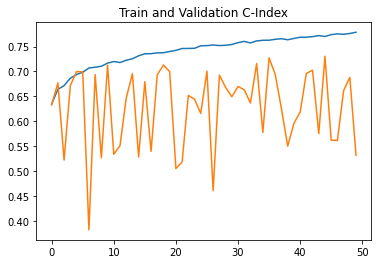

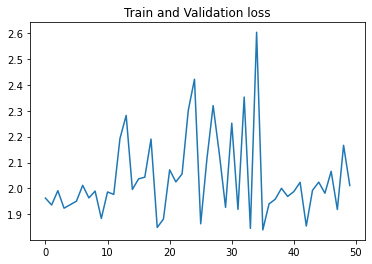

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

history = trainer.history()
plt.plot(history['train_cindices'])
plt.plot(history['val_cindices'])
plt.title('Train and Validation C-Index')
plt.show()


plt.plot(history['val_losses'])
plt.title('Train and Validation loss')
plt.show()

## Evaluation

In [9]:
trainer.evaluation(test_loader, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.41s/it]

0.7418560463541275


0.7418560463541275

## save

In [10]:
model = trainer.get_best_model()
model.to('cpu')
torch.save(model.state_dict(), 'pre_cnn_model2.pt')